# Random Forest Finalised

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [16]:
data = pd.read_csv('../data/bank.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


In [17]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
le = LabelEncoder()
encoded_values = {}  # Dictionary to store mapping of categories to numerical values

data['pdays'] = data['pdays'].replace(['999'], 0)

cat_cols = data.select_dtypes(include=['object']).columns
num_cols = data.select_dtypes(include=np.number).columns.tolist()

for column in cat_cols:
    data[column] = le.fit_transform(data[column])
    encoded_values[column] = dict(zip(le.classes_, le.transform(le.classes_)))

# Print the mapping for each categorical column
for column, mapping in encoded_values.items():
    print(f"{column}: {mapping}")

job: {'admin.': np.int64(0), 'blue-collar': np.int64(1), 'entrepreneur': np.int64(2), 'housemaid': np.int64(3), 'management': np.int64(4), 'retired': np.int64(5), 'self-employed': np.int64(6), 'services': np.int64(7), 'student': np.int64(8), 'technician': np.int64(9), 'unemployed': np.int64(10), 'unknown': np.int64(11)}
marital: {'divorced': np.int64(0), 'married': np.int64(1), 'single': np.int64(2), 'unknown': np.int64(3)}
education: {'basic.4y': np.int64(0), 'basic.6y': np.int64(1), 'basic.9y': np.int64(2), 'high.school': np.int64(3), 'illiterate': np.int64(4), 'professional.course': np.int64(5), 'university.degree': np.int64(6), 'unknown': np.int64(7)}
default: {'no': np.int64(0), 'unknown': np.int64(1), 'yes': np.int64(2)}
housing: {'no': np.int64(0), 'unknown': np.int64(1), 'yes': np.int64(2)}
loan: {'no': np.int64(0), 'unknown': np.int64(1), 'yes': np.int64(2)}
contact: {'cellular': np.int64(0), 'telephone': np.int64(1)}
month: {'apr': np.int64(0), 'aug': np.int64(1), 'dec': np.i

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Define features (X) and target (y)
X = data.drop(columns=['y'])  
y = data['y']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
robust = RobustScaler()
X_train[num_cols] = robust.fit_transform(X_train[num_cols])
X_test[num_cols] = robust.transform(X_test[num_cols])

In [19]:
# Calculate correlations with the target variable ('Income')
correlations = data.corr()['y'].sort_values(ascending=False)

# Print correlations
print(correlations)

y                 1.000000
duration          0.405274
previous          0.230181
poutcome          0.129789
education         0.057799
cons.conf.idx     0.054878
marital           0.046203
age               0.030399
job               0.025122
day_of_week       0.015967
housing           0.011552
loan             -0.004909
month            -0.006065
campaign         -0.066357
default          -0.099352
cons.price.idx   -0.136211
contact          -0.144773
emp.var.rate     -0.298334
euribor3m        -0.307771
pdays            -0.324914
nr.employed      -0.354536
Name: y, dtype: float64


In [20]:
columns_to_drop = ['education', 'cons.conf.idx', 'marital', 'age', 'job', 'day_of_week', 'month', 'campaign', 'default']
data_filtered = data.drop(columns=columns_to_drop)

In [21]:
# Save the preprocessed data
data_filtered.to_csv("../data/rf/filtered.csv", index=False)

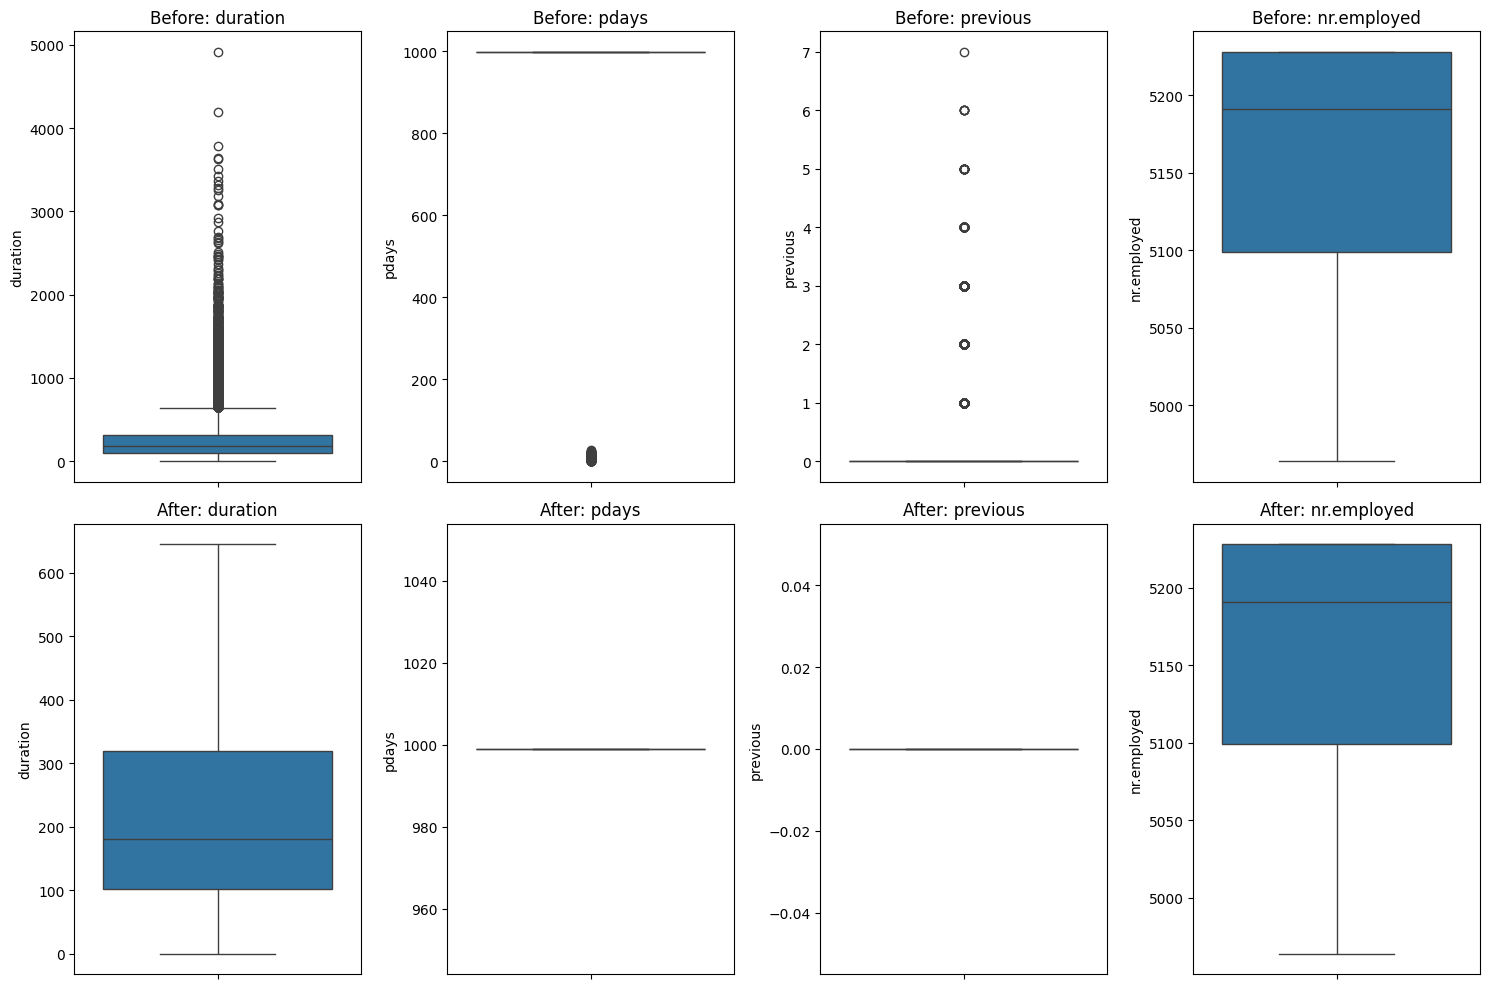

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns


# Define a function to handle outliers
def handle_outliers_iqr(column):
    # Calculate quartiles
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    # Calculate lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count occurrences of outliers
    outliers = (column < lower_bound) | (column > upper_bound)
    outlier_count = outliers.sum()

    # Round outliers to the upper or lower bound
    return column.apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
    
num_cols = ['duration', 'pdays', 'previous', 'nr.employed']
# Apply outlier handling for each numerical column
for column in num_cols:
    data_filtered[column] = handle_outliers_iqr(data_filtered[column])

# Create subplots for the box plots before and after outlier handling
fig, axes = plt.subplots(nrows=2, ncols=len(num_cols), figsize=(15, 10))

# Plot box plots before outlier handling
for i, column in enumerate(num_cols):
    sns.boxplot(y=data[column], ax=axes[0, i])
    axes[0, i].set_title(f'Before: {column}')

# Plot box plots after outlier handling
for i, column in enumerate(num_cols):
    sns.boxplot(y=data_filtered[column], ax=axes[1, i])
    axes[1, i].set_title(f'After: {column}')

# Adjust layout and show plots
plt.tight_layout()
plt.show()

In [23]:
# Save the modified data into another CSV file
output_file_path = "../data/rf/new_data.csv"
data_filtered.to_csv(output_file_path, index=False)

In [24]:
import pandas as pd

# Load the cleaned and transformed dataset
data_filtered = pd.read_csv('../data/rf/new_data.csv')

# Count the occurrences of each class in the target variable
class_counts = data_filtered['y'].value_counts()

# Print the class counts
print("Class Counts:")
print(class_counts)

# Calculate the class distribution as percentages
class_distribution = class_counts / class_counts.sum() * 100

# Print the class distribution
print("\nClass Distribution (%):")
print(class_distribution)

Class Counts:
y
0    36548
1     4640
Name: count, dtype: int64

Class Distribution (%):
y
0    88.734583
1    11.265417
Name: count, dtype: float64


In [25]:
# Import SMOTE
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Resample the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

In [26]:
import pandas as pd

y_resampled_series = pd.Series(y_resampled)

# Print class counts
class_counts = y_resampled_series.value_counts()
print("Class Counts:")
print(class_counts)

# Print class distribution (%)
class_distribution = y_resampled_series.value_counts(normalize=True) * 100
print("\nClass Distribution (%):")
print(class_distribution)

Class Counts:
y
0    36548
1    36548
Name: count, dtype: int64

Class Distribution (%):
y
0    50.0
1    50.0
Name: proportion, dtype: float64


In [27]:
import pandas as pd

# Assuming you have X_resampled and y_resampled after applying SMOTE

# Combine X_resampled and y_resampled into a single DataFrame
resampled_data = pd.DataFrame(X_resampled, columns=X.columns)  # Assuming X has column names
resampled_data['y'] = y_resampled  # y is the target column name

# Save the resampled data to a CSV file
resampled_data.to_csv('../data/rf/resampled_data.csv', index=False)

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


# Load the cleaned and transformed dataset
new_data = pd.read_csv('../data/rf/resampled_data.csv')
# Define features (X) and target (y)
X = new_data.drop(columns=['y']) 
y = new_data['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)

# Evaluate Random Forest Classifier
print("\nRandom Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Classification Report:")
print(classification_report(y_test, rf_predictions))



Random Forest Classifier:
Accuracy: 0.9526675786593707
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7332
           1       0.94      0.97      0.95      7288

    accuracy                           0.95     14620
   macro avg       0.95      0.95      0.95     14620
weighted avg       0.95      0.95      0.95     14620




AUC-ROC Score: 0.9920747240941322


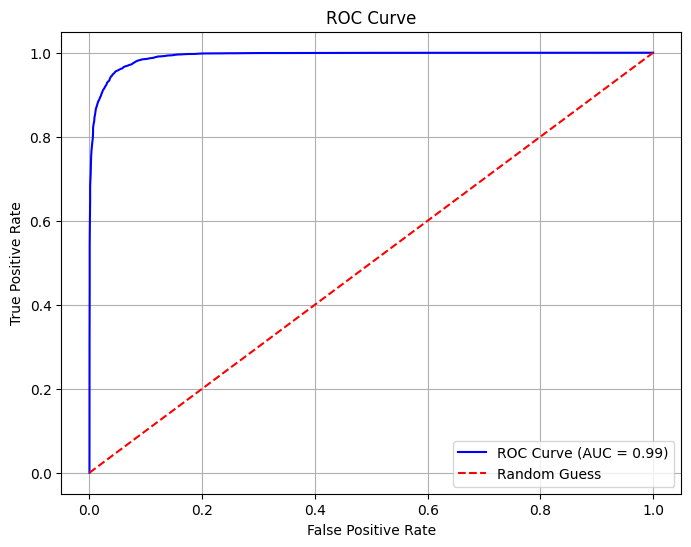

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (1)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# Compute AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("\nAUC-ROC Score:", roc_auc)

# Compute ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()



Confusion Matrix for Random Forest Classifier:


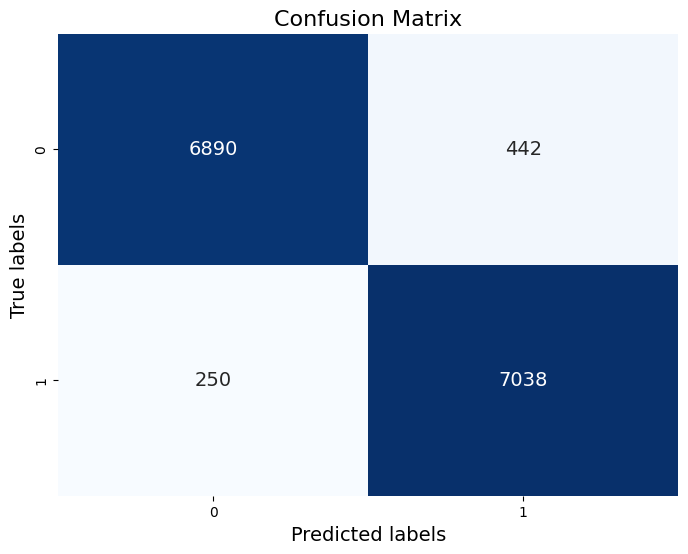

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Print Confusion Matrix for Random Forest Classifier
print("\nConfusion Matrix for Random Forest Classifier:")
cm = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={"size": 14})
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()